# Data Modelling

## Get the data from the previous notebook

In [150]:
import json
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#Get the data from the previous notebook, as csv files, and load them into dataframes
awards_players_df = pd.read_csv('../prep_data/awards_players_df.csv')
coaches_df = pd.read_csv('../prep_data/coaches_df.csv')
players_df = pd.read_csv('../prep_data/players_df.csv')
players_teams_df = pd.read_csv('../prep_data/players_teams_df.csv')
series_post_df = pd.read_csv('../prep_data/series_post_df.csv')
teams_df = pd.read_csv('../prep_data/teams_df.csv')
teams_post_df = pd.read_csv('../prep_data/teams_post_df.csv')

#make a dictionary with all the dataframes
dfs = {'awards_players_df': awards_players_df, 'coaches_df': coaches_df, 'players_df': players_df, 'players_teams_df': players_teams_df, 'series_post_df': series_post_df, 'teams_df': teams_df, 'teams_post_df': teams_post_df}


In [151]:
#Print all the dataframes
for key in dfs:
    print(key)
    print(dfs[key].head())
    print('\n')

awards_players_df
   year    playerID                               award
0     1  thompti01w  All-Star Game Most Valuable Player
1     2  leslili01w  All-Star Game Most Valuable Player
2     3  leslili01w  All-Star Game Most Valuable Player
3     4  teaslni01w  All-Star Game Most Valuable Player
4     6  swoopsh01w  All-Star Game Most Valuable Player


coaches_df
   year  stint  won  lost  post_wins  post_losses     coachID tmID
0     5      0   17    17          1            2  adamsmi01w  WAS
1     1      0   20    12          4            3  adubari99w  NYL
2     2      0   21    11          3            3  adubari99w  NYL
3     3      0   18    14          4            4  adubari99w  NYL
4     4      0   16    18          0            0  adubari99w  NYL


players_df
   firstseason  lastseason  num_seasons       bioID pos  height  weight  \
0            2           9            8  abrossv01w   F    74.0   169.0   
1            4           4            1  adamsjo01w   C    75.0   18

# MODELING

## Decision Tree

Run a simple model on the teams table to predict if a team will make it to the playoffs or not. Let's see how it behaves.

In [159]:
teams_df

# split into train years and test year (year 10)
teams_train_df = teams_df[teams_df['year'] < 10]
teams_test_df = teams_df[teams_df['year'] == 10]

In [160]:
#see all null values in teams_df
teams_df.isnull().sum()

year            0
confID          0
playoff         0
firstRound     62
semis         104
finals        122
o_fta           0
o_3pm           0
o_oreb          0
o_asts          0
o_stl           0
o_to            0
o_blk           0
d_3pa           0
d_oreb          0
d_dreb          0
d_asts          0
d_stl           0
d_to            0
d_blk           0
attend          0
tmID            0
dtype: int64

Accuracy: 0.5384615384615384


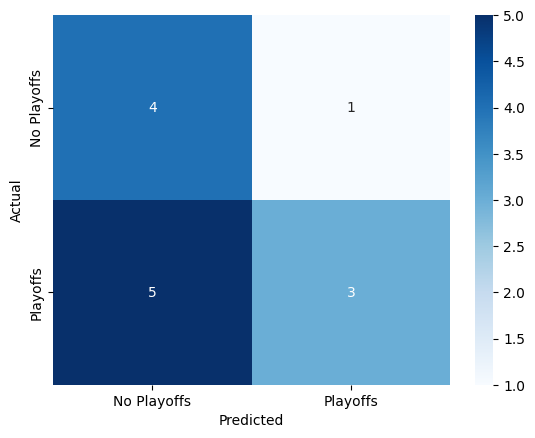

In [161]:
# run a tree decision classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Split the data into features and target label
target_names = ['No Playoffs', 'Playoffs']
feature_names = []
y_train = teams_train_df['playoff']
y_test = teams_test_df['playoff']
X_train = teams_train_df.drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)
X_test = teams_test_df.drop(['playoff', 'year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)

clf = DecisionTreeClassifier()

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Create a confusion matrix to evaluate the model and print with labels
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Modified Accuracy (Top 8 Teams as Playoff): 0.6923076923076923


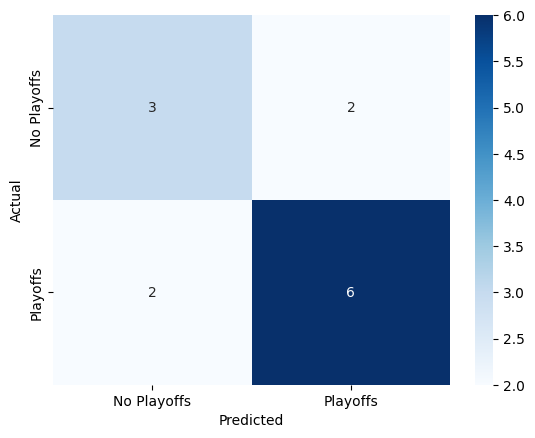

In [162]:
top_teams_indices = y_pred.argsort()[-8:][::-1]  # Get the indices of the top 8 teams

# Convert the labels to numeric format (0 for 'No Playoff', 1 for 'Playoff')
y_pred_numeric = [1 if i in top_teams_indices else 0 for i in range(len(y_pred))]

# Calculate the accuracy of the modified predictions
accuracy = accuracy_score(y_test, y_pred_numeric)
print("Modified Accuracy (Top 8 Teams as Playoff):", accuracy)

# Create a confusion matrix to evaluate the model and print with labels
cm = confusion_matrix(y_test, y_pred_numeric)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## Rolling window

#TODO: THIS IS NOT WORKING YET

In [187]:
# Define the rolling window size (number of past years to consider)
ROLLING_WIN_SIZE = 3  # You can adjust this value
PREDICTION_YEAR = 10

historical_data_df = teams_df[teams_df['year'] < PREDICTION_YEAR]

def create_rolling_window_dataset(df, window_size):
    rolling_window_data = []
    for tmID, group in df.groupby('tmID'):
        group = group.sort_values(by='year')
        for i in range(len(group) - window_size + 1):
            window = group.iloc[i:i + window_size]
            rolling_window_data.append(window)
    return rolling_window_data

In [191]:
# Split the data into features and target label
target_names = ['No Playoff', 'Playoff']

# Create the rolling window datasets for training and testing
rolling_window_train = create_rolling_window_dataset(historical_data_df,  ROLLING_WIN_SIZE)

# Create the training and testing datasets
X_test = pd.DataFrame()
X_train = pd.DataFrame()

for window in rolling_window_train:
    if max(window['year']) == PREDICTION_YEAR - 1:
        X_test = pd.concat([X_test, window], axis=0, ignore_index=True)
    else:
        X_train = pd.concat([X_train, window], axis=0, ignore_index=True)
    
# Calculate weighted moving averages for relevant features using EWMA
weighted_features = ['o_fta', 'o_3pm', 'o_oreb', 'o_asts', 'o_stl', 'o_to', 'd_3pa', 'd_oreb', 'd_dreb', 'd_asts', 'd_stl', 'd_to', 'd_blk']

for feature in weighted_features:
    X_train[feature] = X_train.groupby('tmID')[feature].transform(lambda x: x.ewm(span=ROLLING_WIN_SIZE).mean().shift(1))
    X_test[feature] = X_test.groupby('tmID')[feature].transform(lambda x: x.ewm(span=ROLLING_WIN_SIZE).mean().shift(1))

# Drop the first ROLLING_WIN_SIZE rows since they contain NaN values
X_train = X_train.dropna()
X_test = X_test.dropna()

# Drop the columns that are not needed
X_train = X_train.drop(['year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)
X_test = X_test.drop(['year', 'tmID', 'firstRound', 'semis', 'finals'], axis=1)

# Split the data into features and target label
y_train = X_train['playoff']
y_test = X_test['playoff']
X_train = X_train.drop(['playoff'], axis=1)
X_test = X_test.drop(['playoff'], axis=1)

# Fit the classifier on the training data
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(y_pred)
print(y_test)
print(X_test)


Accuracy: 1.0
[1 1 1 1]
7     1
8     1
25    1
32    1
Name: playoff, dtype: int64
    confID       o_fta       o_3pm      o_oreb  o_asts       o_stl  \
7        0  746.000000  136.000000  406.000000   572.0  213.000000   
8        0  772.000000  150.666667  388.666667   566.0  222.333333   
25       1  684.000000  265.000000  334.000000   640.0  275.000000   
32       1  608.666667  201.000000  333.333333   558.0  270.666667   

          o_to  o_blk       d_3pa      d_oreb      d_dreb      d_asts  \
7   537.000000    117  561.000000  324.000000  760.000000  474.000000   
8   555.000000    118  593.666667  314.000000  773.333333  522.000000   
25  442.000000    159  618.000000  408.000000  875.000000  578.000000   
32  534.666667    150  455.666667  364.666667  805.666667  530.666667   

         d_stl        d_to       d_blk  attend  
7   275.000000  506.000000  108.000000  165738  
8   275.666667  521.333333  114.000000  162669  
25  231.000000  537.000000  126.000000  131524  
32 